# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

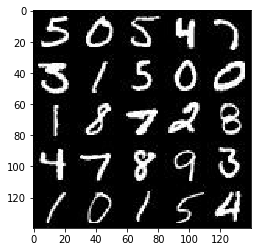

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

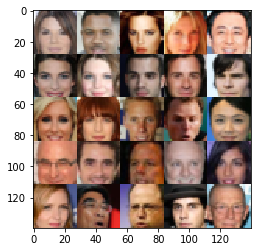

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name="real_input")
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="z_input")
    learn_rate = tf.placeholder(tf.float32, (), name="learn_rate")
    return input_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.1 * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.1 * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.1 * bn3, bn3)
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*256)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(0.1 * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=1, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1 * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.1 * x3, x3)
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, is_train=False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
   
    show_interval_loss = 10
    show_interval_image = 100
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim)).astype(np.float32)
                
                _= sess.run(d_opt, feed_dict={input_real: batch_images, input_z:batch_z, learn_rate: learning_rate})
                _= sess.run(g_opt, feed_dict={input_real: batch_images, input_z:batch_z, learn_rate: learning_rate})
                
                if steps % show_interval_loss == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z, input_real: batch_images})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_interval_image == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                    


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.9737... Generator Loss: 0.6934
Epoch 1/2... Discriminator Loss: 1.2827... Generator Loss: 0.5925
Epoch 1/2... Discriminator Loss: 1.1547... Generator Loss: 0.6588
Epoch 1/2... Discriminator Loss: 4.1169... Generator Loss: 4.7532
Epoch 1/2... Discriminator Loss: 0.6576... Generator Loss: 1.2891
Epoch 1/2... Discriminator Loss: 1.4978... Generator Loss: 1.5744
Epoch 1/2... Discriminator Loss: 1.4784... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 1.6091... Generator Loss: 0.4871
Epoch 1/2... Discriminator Loss: 1.5077... Generator Loss: 0.8239


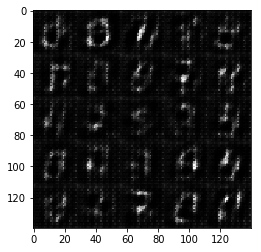

Epoch 1/2... Discriminator Loss: 1.2016... Generator Loss: 1.1192
Epoch 1/2... Discriminator Loss: 1.7810... Generator Loss: 0.3187
Epoch 1/2... Discriminator Loss: 1.7912... Generator Loss: 0.3062
Epoch 1/2... Discriminator Loss: 1.3732... Generator Loss: 0.3998
Epoch 1/2... Discriminator Loss: 1.9273... Generator Loss: 0.2938
Epoch 1/2... Discriminator Loss: 1.4463... Generator Loss: 0.4401
Epoch 1/2... Discriminator Loss: 1.6486... Generator Loss: 1.0926
Epoch 1/2... Discriminator Loss: 1.6192... Generator Loss: 1.3817
Epoch 1/2... Discriminator Loss: 1.3816... Generator Loss: 0.4209
Epoch 1/2... Discriminator Loss: 1.6807... Generator Loss: 0.3106


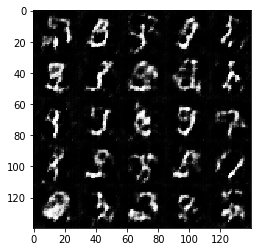

Epoch 1/2... Discriminator Loss: 2.0900... Generator Loss: 0.2002
Epoch 1/2... Discriminator Loss: 1.8189... Generator Loss: 0.2126
Epoch 1/2... Discriminator Loss: 1.6201... Generator Loss: 0.3420
Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 0.7750
Epoch 1/2... Discriminator Loss: 1.2919... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.8877... Generator Loss: 0.2175
Epoch 1/2... Discriminator Loss: 1.8555... Generator Loss: 0.2216
Epoch 1/2... Discriminator Loss: 1.6404... Generator Loss: 0.3555
Epoch 1/2... Discriminator Loss: 2.3183... Generator Loss: 0.1465
Epoch 1/2... Discriminator Loss: 1.3233... Generator Loss: 1.0662


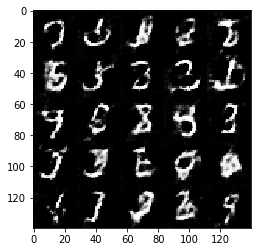

Epoch 1/2... Discriminator Loss: 1.7428... Generator Loss: 0.9501
Epoch 1/2... Discriminator Loss: 1.5192... Generator Loss: 0.4015
Epoch 1/2... Discriminator Loss: 1.5597... Generator Loss: 0.4256
Epoch 1/2... Discriminator Loss: 2.0409... Generator Loss: 0.1908
Epoch 1/2... Discriminator Loss: 2.0361... Generator Loss: 0.2516
Epoch 1/2... Discriminator Loss: 1.6606... Generator Loss: 0.2986
Epoch 1/2... Discriminator Loss: 1.3266... Generator Loss: 0.6230
Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 0.9092
Epoch 1/2... Discriminator Loss: 1.4601... Generator Loss: 1.5071
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 0.9509


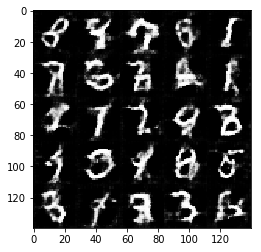

Epoch 1/2... Discriminator Loss: 1.5622... Generator Loss: 1.2838
Epoch 1/2... Discriminator Loss: 1.3574... Generator Loss: 0.8494
Epoch 1/2... Discriminator Loss: 1.3729... Generator Loss: 0.6107
Epoch 1/2... Discriminator Loss: 1.1858... Generator Loss: 1.0307
Epoch 1/2... Discriminator Loss: 1.5042... Generator Loss: 0.4505
Epoch 1/2... Discriminator Loss: 1.3130... Generator Loss: 0.9597
Epoch 1/2... Discriminator Loss: 1.2433... Generator Loss: 1.1923
Epoch 1/2... Discriminator Loss: 1.5566... Generator Loss: 0.3017
Epoch 1/2... Discriminator Loss: 1.4337... Generator Loss: 0.4270
Epoch 1/2... Discriminator Loss: 1.7343... Generator Loss: 0.2880


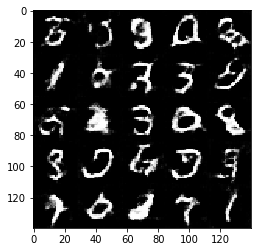

Epoch 1/2... Discriminator Loss: 1.5158... Generator Loss: 0.3819
Epoch 1/2... Discriminator Loss: 2.2411... Generator Loss: 2.0480
Epoch 1/2... Discriminator Loss: 1.3222... Generator Loss: 1.0530
Epoch 1/2... Discriminator Loss: 1.2644... Generator Loss: 0.7239
Epoch 1/2... Discriminator Loss: 1.4828... Generator Loss: 0.7174
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 1.0424
Epoch 1/2... Discriminator Loss: 1.3883... Generator Loss: 0.7608
Epoch 1/2... Discriminator Loss: 1.3608... Generator Loss: 0.8116
Epoch 1/2... Discriminator Loss: 1.5630... Generator Loss: 0.3371
Epoch 1/2... Discriminator Loss: 1.3396... Generator Loss: 0.7170


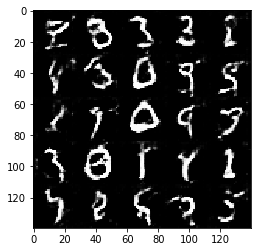

Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.9938
Epoch 1/2... Discriminator Loss: 1.1244... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 1.2711... Generator Loss: 0.7178
Epoch 1/2... Discriminator Loss: 1.2385... Generator Loss: 0.5544
Epoch 1/2... Discriminator Loss: 1.3259... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 1.1459... Generator Loss: 1.3480
Epoch 1/2... Discriminator Loss: 1.2682... Generator Loss: 1.0298
Epoch 1/2... Discriminator Loss: 1.4484... Generator Loss: 1.8146
Epoch 1/2... Discriminator Loss: 1.7054... Generator Loss: 0.2933
Epoch 1/2... Discriminator Loss: 1.6441... Generator Loss: 0.2960


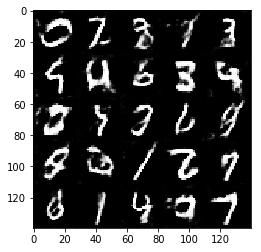

Epoch 1/2... Discriminator Loss: 1.7520... Generator Loss: 0.2513
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.4932
Epoch 1/2... Discriminator Loss: 1.5507... Generator Loss: 0.3703
Epoch 1/2... Discriminator Loss: 1.2787... Generator Loss: 2.1108
Epoch 1/2... Discriminator Loss: 1.5411... Generator Loss: 0.3632
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 0.4452
Epoch 1/2... Discriminator Loss: 1.6433... Generator Loss: 0.2958
Epoch 1/2... Discriminator Loss: 1.6203... Generator Loss: 0.3235
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 0.9942
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 0.6873


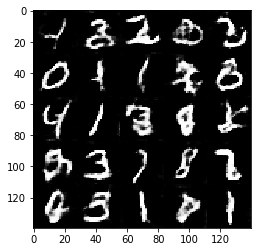

Epoch 1/2... Discriminator Loss: 1.0057... Generator Loss: 0.8396
Epoch 1/2... Discriminator Loss: 1.1526... Generator Loss: 0.6421
Epoch 1/2... Discriminator Loss: 1.4603... Generator Loss: 0.3543
Epoch 1/2... Discriminator Loss: 1.5546... Generator Loss: 0.4132
Epoch 1/2... Discriminator Loss: 1.8008... Generator Loss: 0.2380
Epoch 1/2... Discriminator Loss: 0.9669... Generator Loss: 1.6561
Epoch 1/2... Discriminator Loss: 1.0652... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.2405... Generator Loss: 0.6604
Epoch 1/2... Discriminator Loss: 1.9925... Generator Loss: 0.1836
Epoch 1/2... Discriminator Loss: 1.1306... Generator Loss: 0.6731


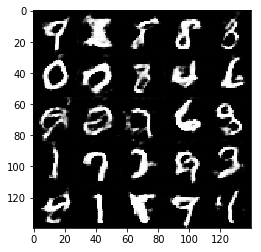

Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.7234
Epoch 1/2... Discriminator Loss: 1.2648... Generator Loss: 0.5347
Epoch 1/2... Discriminator Loss: 1.1297... Generator Loss: 0.8502
Epoch 1/2... Discriminator Loss: 1.8408... Generator Loss: 0.2451
Epoch 1/2... Discriminator Loss: 1.0690... Generator Loss: 1.1884
Epoch 1/2... Discriminator Loss: 1.6635... Generator Loss: 0.2940
Epoch 1/2... Discriminator Loss: 0.8255... Generator Loss: 1.0966
Epoch 1/2... Discriminator Loss: 1.1851... Generator Loss: 0.8507
Epoch 1/2... Discriminator Loss: 1.0897... Generator Loss: 0.9885
Epoch 1/2... Discriminator Loss: 1.0585... Generator Loss: 0.6515


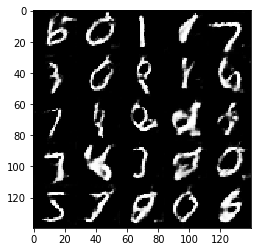

Epoch 1/2... Discriminator Loss: 1.7839... Generator Loss: 0.2641
Epoch 1/2... Discriminator Loss: 1.2157... Generator Loss: 0.6180
Epoch 1/2... Discriminator Loss: 0.9792... Generator Loss: 0.7581
Epoch 1/2... Discriminator Loss: 1.0884... Generator Loss: 1.7702
Epoch 1/2... Discriminator Loss: 1.1972... Generator Loss: 0.9809
Epoch 1/2... Discriminator Loss: 1.6860... Generator Loss: 0.2598
Epoch 1/2... Discriminator Loss: 1.3521... Generator Loss: 0.4671
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 1.8750
Epoch 1/2... Discriminator Loss: 0.6834... Generator Loss: 1.4038
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 0.8463


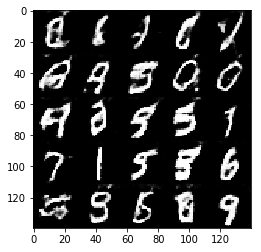

Epoch 1/2... Discriminator Loss: 1.0184... Generator Loss: 1.1401
Epoch 1/2... Discriminator Loss: 1.4680... Generator Loss: 0.4160
Epoch 1/2... Discriminator Loss: 1.0435... Generator Loss: 0.7280
Epoch 1/2... Discriminator Loss: 1.5235... Generator Loss: 0.3952
Epoch 1/2... Discriminator Loss: 1.1855... Generator Loss: 0.5497
Epoch 1/2... Discriminator Loss: 1.6526... Generator Loss: 0.2616
Epoch 1/2... Discriminator Loss: 1.7062... Generator Loss: 0.2957
Epoch 1/2... Discriminator Loss: 1.0668... Generator Loss: 1.2631
Epoch 1/2... Discriminator Loss: 0.9104... Generator Loss: 1.2983
Epoch 1/2... Discriminator Loss: 1.3402... Generator Loss: 1.1517


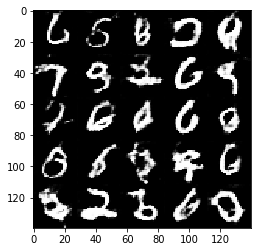

Epoch 1/2... Discriminator Loss: 1.2323... Generator Loss: 0.5061
Epoch 1/2... Discriminator Loss: 1.1558... Generator Loss: 0.6161
Epoch 1/2... Discriminator Loss: 1.1544... Generator Loss: 1.0641
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.0923
Epoch 1/2... Discriminator Loss: 2.0729... Generator Loss: 0.2086
Epoch 1/2... Discriminator Loss: 1.6509... Generator Loss: 0.3204
Epoch 1/2... Discriminator Loss: 1.0166... Generator Loss: 0.7370
Epoch 1/2... Discriminator Loss: 2.2237... Generator Loss: 0.1508
Epoch 1/2... Discriminator Loss: 1.5256... Generator Loss: 0.2892
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 0.6383


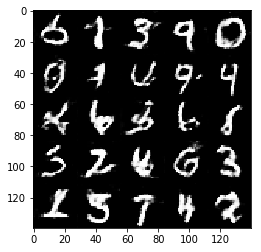

Epoch 1/2... Discriminator Loss: 0.9420... Generator Loss: 0.9746
Epoch 1/2... Discriminator Loss: 1.5476... Generator Loss: 0.3278
Epoch 1/2... Discriminator Loss: 0.9784... Generator Loss: 1.6556
Epoch 1/2... Discriminator Loss: 1.0144... Generator Loss: 1.1916
Epoch 1/2... Discriminator Loss: 1.4955... Generator Loss: 0.3277
Epoch 1/2... Discriminator Loss: 0.6696... Generator Loss: 1.3850
Epoch 1/2... Discriminator Loss: 0.8701... Generator Loss: 0.8567
Epoch 1/2... Discriminator Loss: 1.4255... Generator Loss: 0.4175
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.4710
Epoch 1/2... Discriminator Loss: 1.2086... Generator Loss: 0.5635


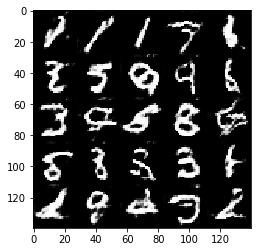

Epoch 1/2... Discriminator Loss: 1.9348... Generator Loss: 0.2048
Epoch 1/2... Discriminator Loss: 0.5883... Generator Loss: 1.3085
Epoch 1/2... Discriminator Loss: 0.8717... Generator Loss: 0.8760
Epoch 1/2... Discriminator Loss: 0.7875... Generator Loss: 1.0025
Epoch 1/2... Discriminator Loss: 1.1812... Generator Loss: 0.9023
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 0.6190
Epoch 1/2... Discriminator Loss: 0.5416... Generator Loss: 1.4381
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.3385
Epoch 1/2... Discriminator Loss: 0.7585... Generator Loss: 1.5788
Epoch 1/2... Discriminator Loss: 0.9350... Generator Loss: 0.8667


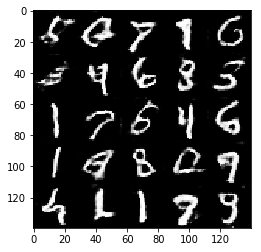

Epoch 1/2... Discriminator Loss: 1.7350... Generator Loss: 0.2976
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.0471
Epoch 1/2... Discriminator Loss: 0.5334... Generator Loss: 1.8450
Epoch 1/2... Discriminator Loss: 0.6218... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 1.4271... Generator Loss: 3.0565
Epoch 1/2... Discriminator Loss: 0.8896... Generator Loss: 0.8555
Epoch 1/2... Discriminator Loss: 1.1644... Generator Loss: 0.5389
Epoch 1/2... Discriminator Loss: 0.3938... Generator Loss: 1.8295
Epoch 1/2... Discriminator Loss: 2.0468... Generator Loss: 0.1939
Epoch 1/2... Discriminator Loss: 1.0070... Generator Loss: 0.6561


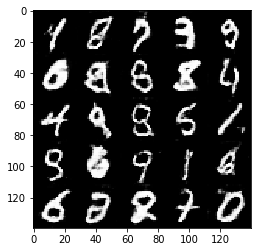

Epoch 1/2... Discriminator Loss: 0.9112... Generator Loss: 0.7853
Epoch 1/2... Discriminator Loss: 2.1316... Generator Loss: 0.1683
Epoch 1/2... Discriminator Loss: 1.0202... Generator Loss: 1.4899
Epoch 1/2... Discriminator Loss: 2.1963... Generator Loss: 0.1719
Epoch 1/2... Discriminator Loss: 1.1408... Generator Loss: 0.6253
Epoch 1/2... Discriminator Loss: 1.7583... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 1.5157... Generator Loss: 0.3624
Epoch 1/2... Discriminator Loss: 1.3215... Generator Loss: 0.4973
Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 1.4775
Epoch 1/2... Discriminator Loss: 0.4724... Generator Loss: 1.7010


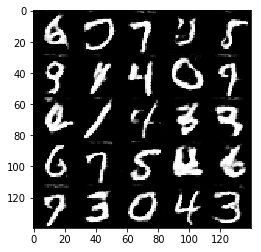

Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 0.8466
Epoch 1/2... Discriminator Loss: 0.8524... Generator Loss: 0.7705
Epoch 1/2... Discriminator Loss: 0.7288... Generator Loss: 1.1046
Epoch 1/2... Discriminator Loss: 0.7610... Generator Loss: 1.0629
Epoch 1/2... Discriminator Loss: 2.4935... Generator Loss: 4.4046
Epoch 1/2... Discriminator Loss: 0.6053... Generator Loss: 2.3288
Epoch 1/2... Discriminator Loss: 0.7049... Generator Loss: 0.9301
Epoch 1/2... Discriminator Loss: 0.8760... Generator Loss: 0.9343
Epoch 1/2... Discriminator Loss: 1.0527... Generator Loss: 0.7555


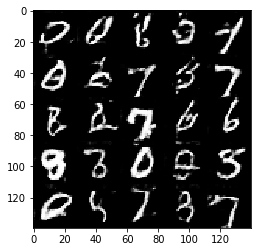

Epoch 1/2... Discriminator Loss: 2.2381... Generator Loss: 0.1430
Epoch 1/2... Discriminator Loss: 1.3064... Generator Loss: 0.4864
Epoch 1/2... Discriminator Loss: 0.8604... Generator Loss: 1.1026
Epoch 1/2... Discriminator Loss: 1.8274... Generator Loss: 0.2431
Epoch 1/2... Discriminator Loss: 0.8369... Generator Loss: 1.1984
Epoch 1/2... Discriminator Loss: 1.3749... Generator Loss: 0.4210
Epoch 1/2... Discriminator Loss: 0.7035... Generator Loss: 1.4092
Epoch 2/2... Discriminator Loss: 0.8739... Generator Loss: 0.8513
Epoch 2/2... Discriminator Loss: 0.7945... Generator Loss: 2.3514
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 0.7837


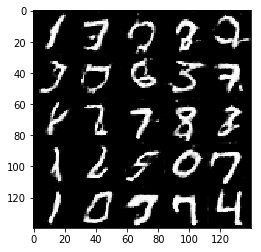

Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.6384
Epoch 2/2... Discriminator Loss: 0.4935... Generator Loss: 2.4542
Epoch 2/2... Discriminator Loss: 1.2559... Generator Loss: 0.4613
Epoch 2/2... Discriminator Loss: 1.1654... Generator Loss: 0.7060
Epoch 2/2... Discriminator Loss: 2.2418... Generator Loss: 0.1407
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 1.3495
Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 0.7682
Epoch 2/2... Discriminator Loss: 2.9917... Generator Loss: 5.1469
Epoch 2/2... Discriminator Loss: 0.7435... Generator Loss: 2.4286
Epoch 2/2... Discriminator Loss: 1.5695... Generator Loss: 0.3120


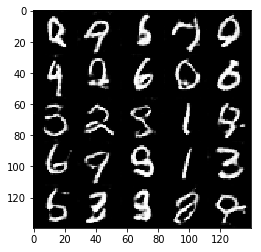

Epoch 2/2... Discriminator Loss: 0.5909... Generator Loss: 1.2837
Epoch 2/2... Discriminator Loss: 0.9172... Generator Loss: 0.7720
Epoch 2/2... Discriminator Loss: 0.6943... Generator Loss: 1.1513
Epoch 2/2... Discriminator Loss: 3.0973... Generator Loss: 0.0771
Epoch 2/2... Discriminator Loss: 0.6906... Generator Loss: 1.0440
Epoch 2/2... Discriminator Loss: 1.2913... Generator Loss: 0.6949
Epoch 2/2... Discriminator Loss: 0.7385... Generator Loss: 1.0682
Epoch 2/2... Discriminator Loss: 0.8541... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 2.0958... Generator Loss: 0.2276
Epoch 2/2... Discriminator Loss: 0.2926... Generator Loss: 2.1600


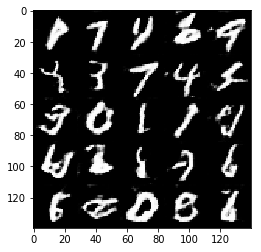

Epoch 2/2... Discriminator Loss: 0.6700... Generator Loss: 1.3191
Epoch 2/2... Discriminator Loss: 0.6636... Generator Loss: 1.1589
Epoch 2/2... Discriminator Loss: 0.6133... Generator Loss: 1.2164
Epoch 2/2... Discriminator Loss: 0.1823... Generator Loss: 2.3518
Epoch 2/2... Discriminator Loss: 1.3919... Generator Loss: 0.4087
Epoch 2/2... Discriminator Loss: 2.4109... Generator Loss: 0.1846
Epoch 2/2... Discriminator Loss: 0.9785... Generator Loss: 0.7386
Epoch 2/2... Discriminator Loss: 0.5034... Generator Loss: 1.2606
Epoch 2/2... Discriminator Loss: 0.7075... Generator Loss: 1.1207
Epoch 2/2... Discriminator Loss: 0.3665... Generator Loss: 1.9356


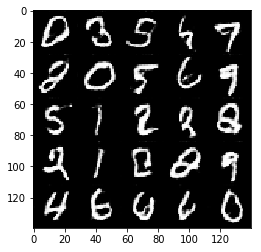

Epoch 2/2... Discriminator Loss: 2.2574... Generator Loss: 0.2263
Epoch 2/2... Discriminator Loss: 0.6721... Generator Loss: 1.1087
Epoch 2/2... Discriminator Loss: 0.5434... Generator Loss: 1.2890
Epoch 2/2... Discriminator Loss: 0.4646... Generator Loss: 2.7548
Epoch 2/2... Discriminator Loss: 0.3307... Generator Loss: 2.3912
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 0.8611
Epoch 2/2... Discriminator Loss: 1.0188... Generator Loss: 0.5971
Epoch 2/2... Discriminator Loss: 1.6865... Generator Loss: 0.3268
Epoch 2/2... Discriminator Loss: 0.8306... Generator Loss: 3.1330
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 1.3455


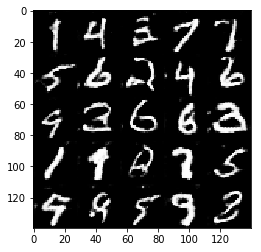

Epoch 2/2... Discriminator Loss: 2.6762... Generator Loss: 0.1310
Epoch 2/2... Discriminator Loss: 0.7158... Generator Loss: 0.9555
Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.5557
Epoch 2/2... Discriminator Loss: 1.2999... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 0.5260... Generator Loss: 1.6472
Epoch 2/2... Discriminator Loss: 0.7012... Generator Loss: 2.9067
Epoch 2/2... Discriminator Loss: 0.6062... Generator Loss: 1.6224
Epoch 2/2... Discriminator Loss: 0.6396... Generator Loss: 1.1429
Epoch 2/2... Discriminator Loss: 0.4255... Generator Loss: 1.7126
Epoch 2/2... Discriminator Loss: 0.2281... Generator Loss: 2.2901


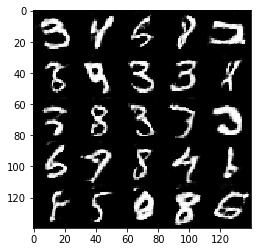

Epoch 2/2... Discriminator Loss: 1.1818... Generator Loss: 0.6053
Epoch 2/2... Discriminator Loss: 0.5465... Generator Loss: 1.4416
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.0365
Epoch 2/2... Discriminator Loss: 1.4140... Generator Loss: 0.4840
Epoch 2/2... Discriminator Loss: 1.8544... Generator Loss: 0.4142
Epoch 2/2... Discriminator Loss: 0.8711... Generator Loss: 0.7013
Epoch 2/2... Discriminator Loss: 0.6480... Generator Loss: 1.2944
Epoch 2/2... Discriminator Loss: 0.6909... Generator Loss: 1.1452
Epoch 2/2... Discriminator Loss: 3.7716... Generator Loss: 0.0434
Epoch 2/2... Discriminator Loss: 1.2425... Generator Loss: 0.5070


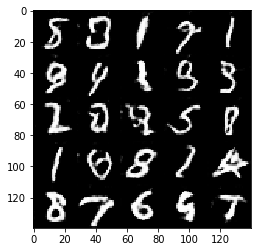

Epoch 2/2... Discriminator Loss: 0.6409... Generator Loss: 1.1579
Epoch 2/2... Discriminator Loss: 0.6507... Generator Loss: 1.1206
Epoch 2/2... Discriminator Loss: 0.5113... Generator Loss: 1.2667
Epoch 2/2... Discriminator Loss: 0.3467... Generator Loss: 2.4453
Epoch 2/2... Discriminator Loss: 0.8529... Generator Loss: 2.7400
Epoch 2/2... Discriminator Loss: 1.1806... Generator Loss: 3.9347
Epoch 2/2... Discriminator Loss: 0.4022... Generator Loss: 1.5076
Epoch 2/2... Discriminator Loss: 0.8679... Generator Loss: 4.0003
Epoch 2/2... Discriminator Loss: 0.5435... Generator Loss: 3.0341
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.1696


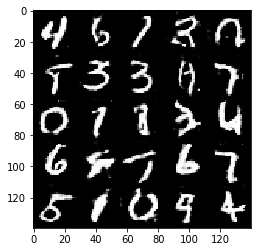

Epoch 2/2... Discriminator Loss: 1.5397... Generator Loss: 0.3690
Epoch 2/2... Discriminator Loss: 0.4261... Generator Loss: 1.8385
Epoch 2/2... Discriminator Loss: 1.3579... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 1.2636... Generator Loss: 0.5838
Epoch 2/2... Discriminator Loss: 0.2625... Generator Loss: 2.1741
Epoch 2/2... Discriminator Loss: 0.4443... Generator Loss: 1.6043
Epoch 2/2... Discriminator Loss: 0.6940... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 0.4015... Generator Loss: 2.5323
Epoch 2/2... Discriminator Loss: 0.6876... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 0.2849... Generator Loss: 2.0129


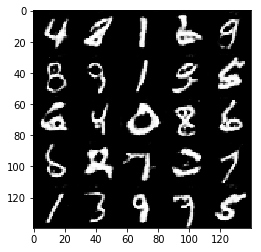

Epoch 2/2... Discriminator Loss: 0.4629... Generator Loss: 1.5676
Epoch 2/2... Discriminator Loss: 0.6060... Generator Loss: 1.9481
Epoch 2/2... Discriminator Loss: 3.0953... Generator Loss: 0.0769
Epoch 2/2... Discriminator Loss: 0.5091... Generator Loss: 1.9613
Epoch 2/2... Discriminator Loss: 0.4001... Generator Loss: 1.5413
Epoch 2/2... Discriminator Loss: 0.4826... Generator Loss: 1.3997
Epoch 2/2... Discriminator Loss: 0.7023... Generator Loss: 0.9523
Epoch 2/2... Discriminator Loss: 0.4457... Generator Loss: 1.6565
Epoch 2/2... Discriminator Loss: 0.6129... Generator Loss: 1.3157
Epoch 2/2... Discriminator Loss: 0.5909... Generator Loss: 1.4345


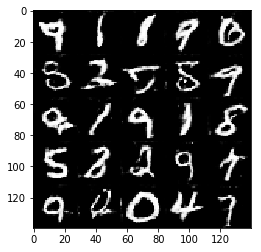

Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 1.6938
Epoch 2/2... Discriminator Loss: 2.9609... Generator Loss: 0.1165
Epoch 2/2... Discriminator Loss: 0.4604... Generator Loss: 1.8758
Epoch 2/2... Discriminator Loss: 0.8302... Generator Loss: 1.1844
Epoch 2/2... Discriminator Loss: 0.8220... Generator Loss: 0.8586
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 0.9191
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 2.8512
Epoch 2/2... Discriminator Loss: 0.6566... Generator Loss: 1.0097
Epoch 2/2... Discriminator Loss: 0.7313... Generator Loss: 1.1245
Epoch 2/2... Discriminator Loss: 0.5001... Generator Loss: 1.6107


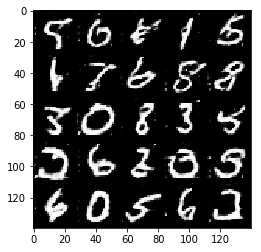

Epoch 2/2... Discriminator Loss: 0.9444... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.7322... Generator Loss: 1.3231
Epoch 2/2... Discriminator Loss: 1.6763... Generator Loss: 0.4725
Epoch 2/2... Discriminator Loss: 0.5585... Generator Loss: 1.3427
Epoch 2/2... Discriminator Loss: 0.5858... Generator Loss: 1.2281
Epoch 2/2... Discriminator Loss: 0.3118... Generator Loss: 2.0256
Epoch 2/2... Discriminator Loss: 0.3958... Generator Loss: 1.6449
Epoch 2/2... Discriminator Loss: 3.7415... Generator Loss: 6.6009
Epoch 2/2... Discriminator Loss: 1.3775... Generator Loss: 3.2617
Epoch 2/2... Discriminator Loss: 1.1362... Generator Loss: 0.6149


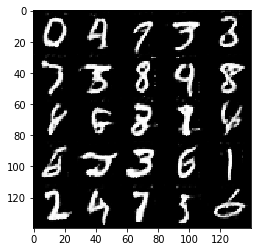

Epoch 2/2... Discriminator Loss: 0.5519... Generator Loss: 1.7903
Epoch 2/2... Discriminator Loss: 0.7884... Generator Loss: 1.1343
Epoch 2/2... Discriminator Loss: 0.4729... Generator Loss: 1.3933
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.0074
Epoch 2/2... Discriminator Loss: 0.9699... Generator Loss: 0.8750
Epoch 2/2... Discriminator Loss: 0.4912... Generator Loss: 1.6400
Epoch 2/2... Discriminator Loss: 0.7613... Generator Loss: 0.8948
Epoch 2/2... Discriminator Loss: 0.3249... Generator Loss: 1.6938
Epoch 2/2... Discriminator Loss: 0.4465... Generator Loss: 2.9398
Epoch 2/2... Discriminator Loss: 0.7685... Generator Loss: 1.0398


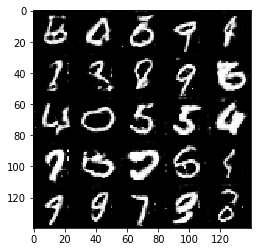

Epoch 2/2... Discriminator Loss: 0.9912... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 0.8485... Generator Loss: 0.8483
Epoch 2/2... Discriminator Loss: 0.4240... Generator Loss: 1.5293
Epoch 2/2... Discriminator Loss: 0.5749... Generator Loss: 3.5336
Epoch 2/2... Discriminator Loss: 0.8862... Generator Loss: 3.7403
Epoch 2/2... Discriminator Loss: 1.0019... Generator Loss: 0.8771
Epoch 2/2... Discriminator Loss: 0.5600... Generator Loss: 1.1099
Epoch 2/2... Discriminator Loss: 0.4830... Generator Loss: 1.3542
Epoch 2/2... Discriminator Loss: 3.1136... Generator Loss: 0.0983
Epoch 2/2... Discriminator Loss: 0.8171... Generator Loss: 1.1228


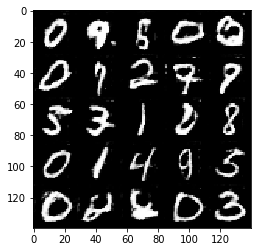

Epoch 2/2... Discriminator Loss: 0.0828... Generator Loss: 3.5275
Epoch 2/2... Discriminator Loss: 0.3497... Generator Loss: 1.9157
Epoch 2/2... Discriminator Loss: 0.4253... Generator Loss: 1.5289
Epoch 2/2... Discriminator Loss: 0.9756... Generator Loss: 0.8040
Epoch 2/2... Discriminator Loss: 2.7954... Generator Loss: 0.1092
Epoch 2/2... Discriminator Loss: 0.3764... Generator Loss: 2.7398
Epoch 2/2... Discriminator Loss: 0.6548... Generator Loss: 1.0706
Epoch 2/2... Discriminator Loss: 0.3192... Generator Loss: 1.9683
Epoch 2/2... Discriminator Loss: 0.4399... Generator Loss: 1.3977
Epoch 2/2... Discriminator Loss: 0.2792... Generator Loss: 2.0415


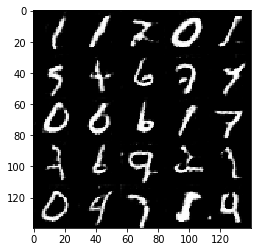

Epoch 2/2... Discriminator Loss: 0.7465... Generator Loss: 1.0530
Epoch 2/2... Discriminator Loss: 1.0819... Generator Loss: 0.8192
Epoch 2/2... Discriminator Loss: 0.3587... Generator Loss: 1.6688
Epoch 2/2... Discriminator Loss: 0.3152... Generator Loss: 2.7252
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 1.6392
Epoch 2/2... Discriminator Loss: 0.3670... Generator Loss: 1.5639
Epoch 2/2... Discriminator Loss: 0.3011... Generator Loss: 1.9797
Epoch 2/2... Discriminator Loss: 0.2865... Generator Loss: 2.2470
Epoch 2/2... Discriminator Loss: 2.1276... Generator Loss: 5.8993
Epoch 2/2... Discriminator Loss: 0.3202... Generator Loss: 2.5656


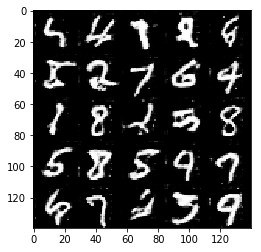

Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.6768
Epoch 2/2... Discriminator Loss: 0.7587... Generator Loss: 0.9607
Epoch 2/2... Discriminator Loss: 0.2733... Generator Loss: 1.8277
Epoch 2/2... Discriminator Loss: 0.5422... Generator Loss: 2.8137
Epoch 2/2... Discriminator Loss: 0.4856... Generator Loss: 1.2844
Epoch 2/2... Discriminator Loss: 0.6328... Generator Loss: 1.0798
Epoch 2/2... Discriminator Loss: 0.7425... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 0.3133... Generator Loss: 1.9297
Epoch 2/2... Discriminator Loss: 0.4628... Generator Loss: 1.6133
Epoch 2/2... Discriminator Loss: 0.5663... Generator Loss: 1.6936


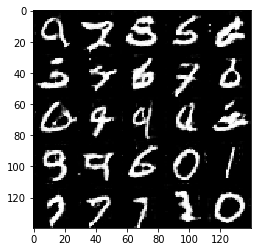

Epoch 2/2... Discriminator Loss: 0.5727... Generator Loss: 1.4632
Epoch 2/2... Discriminator Loss: 0.2940... Generator Loss: 1.9039
Epoch 2/2... Discriminator Loss: 0.5122... Generator Loss: 1.6209
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 0.2361... Generator Loss: 2.4849
Epoch 2/2... Discriminator Loss: 1.0899... Generator Loss: 0.6246
Epoch 2/2... Discriminator Loss: 0.7174... Generator Loss: 1.3420
Epoch 2/2... Discriminator Loss: 0.6849... Generator Loss: 0.9662
Epoch 2/2... Discriminator Loss: 0.5844... Generator Loss: 1.2613
Epoch 2/2... Discriminator Loss: 1.1847... Generator Loss: 0.6550


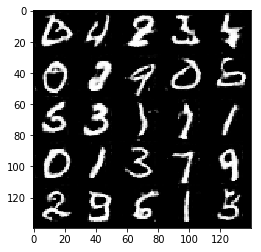

Epoch 2/2... Discriminator Loss: 2.5039... Generator Loss: 0.2028
Epoch 2/2... Discriminator Loss: 2.0488... Generator Loss: 0.2309
Epoch 2/2... Discriminator Loss: 1.6857... Generator Loss: 0.3983
Epoch 2/2... Discriminator Loss: 0.5275... Generator Loss: 2.8475
Epoch 2/2... Discriminator Loss: 0.9506... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 0.5772... Generator Loss: 1.2570
Epoch 2/2... Discriminator Loss: 3.1676... Generator Loss: 0.1687
Epoch 2/2... Discriminator Loss: 0.3172... Generator Loss: 1.8653
Epoch 2/2... Discriminator Loss: 0.5106... Generator Loss: 1.2773
Epoch 2/2... Discriminator Loss: 0.5423... Generator Loss: 1.2928


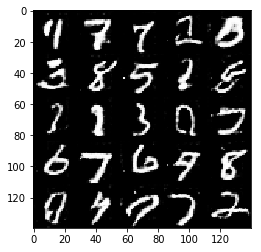

Epoch 2/2... Discriminator Loss: 0.2498... Generator Loss: 1.8379
Epoch 2/2... Discriminator Loss: 0.9402... Generator Loss: 0.9821
Epoch 2/2... Discriminator Loss: 0.3887... Generator Loss: 1.6582
Epoch 2/2... Discriminator Loss: 0.3775... Generator Loss: 1.7323
Epoch 2/2... Discriminator Loss: 0.1769... Generator Loss: 2.5830


In [14]:
batch_size = 32
z_dim = 80
learning_rate = 0.002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 3.7527
Epoch 1/1... Discriminator Loss: 0.2809... Generator Loss: 2.4394
Epoch 1/1... Discriminator Loss: 8.5753... Generator Loss: 7.7134
Epoch 1/1... Discriminator Loss: 2.2681... Generator Loss: 1.5060
Epoch 1/1... Discriminator Loss: 1.4955... Generator Loss: 2.1755
Epoch 1/1... Discriminator Loss: 1.6664... Generator Loss: 1.4440
Epoch 1/1... Discriminator Loss: 1.6103... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 2.0182... Generator Loss: 1.4271
Epoch 1/1... Discriminator Loss: 1.8732... Generator Loss: 0.4252
Epoch 1/1... Discriminator Loss: 1.7061... Generator Loss: 0.6867


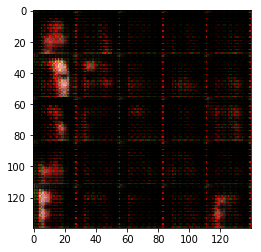

Epoch 1/1... Discriminator Loss: 2.2165... Generator Loss: 0.1764
Epoch 1/1... Discriminator Loss: 1.7217... Generator Loss: 0.3629
Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.5735
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 1.1839
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 1.5798... Generator Loss: 0.6762
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.5051
Epoch 1/1... Discriminator Loss: 1.6942... Generator Loss: 1.6395
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.8227


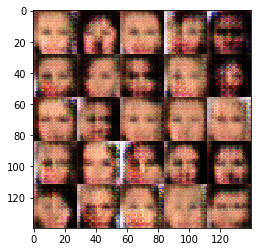

Epoch 1/1... Discriminator Loss: 1.6785... Generator Loss: 0.5226
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.6644
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.6362... Generator Loss: 0.6097
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.7159... Generator Loss: 0.3844


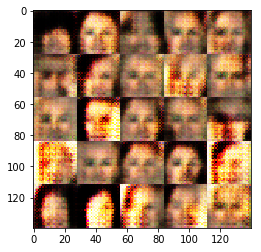

Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.7574... Generator Loss: 0.2858
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.3777
Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.8230... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 1.5991... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.3729... Generator Loss: 0.5541


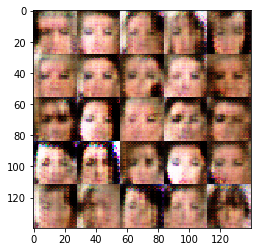

Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 1.2261
Epoch 1/1... Discriminator Loss: 1.7561... Generator Loss: 0.2562
Epoch 1/1... Discriminator Loss: 1.5043... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6262
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6737
Epoch 1/1... Discriminator Loss: 1.4343... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.7816


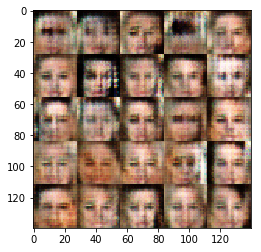

Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.5250... Generator Loss: 1.1293
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.5783
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4533... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.6648


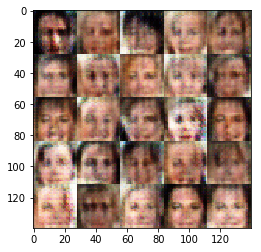

Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4743... Generator Loss: 0.4920
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.3588... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.3825... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 1.0098
Epoch 1/1... Discriminator Loss: 1.2547... Generator Loss: 0.8935


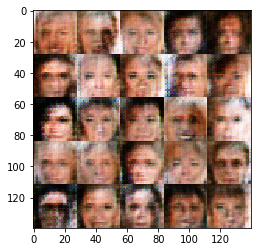

Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.3568... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 2.3067... Generator Loss: 0.1588
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.4428... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.5616... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.2597... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.6257


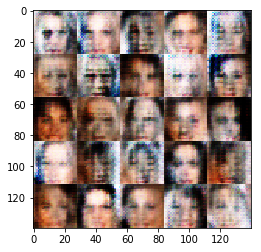

Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.8180
Epoch 1/1... Discriminator Loss: 1.1998... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.3757... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.3959
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.6676


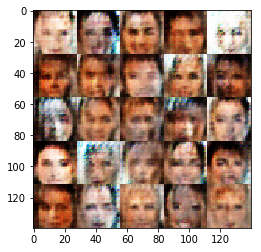

Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.5832
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.4598
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5975
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.3816


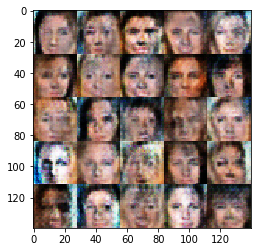

Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.8606
Epoch 1/1... Discriminator Loss: 1.3589... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.4637
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.5614
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.6069
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.5962


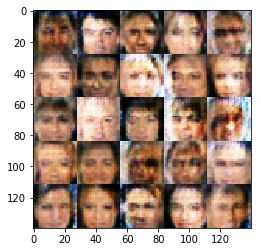

Epoch 1/1... Discriminator Loss: 1.3260... Generator Loss: 0.6053
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.3451... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.3185... Generator Loss: 0.6116
Epoch 1/1... Discriminator Loss: 1.3041... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.5187
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 1.0088


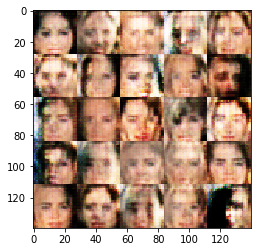

Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.7653
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.5610
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.5087... Generator Loss: 0.4123


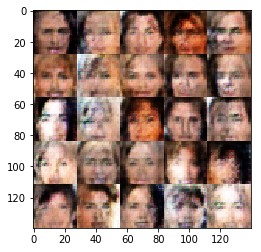

Epoch 1/1... Discriminator Loss: 1.7381... Generator Loss: 0.4083
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.6771
Epoch 1/1... Discriminator Loss: 1.2963... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.2715... Generator Loss: 0.6332
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.6152


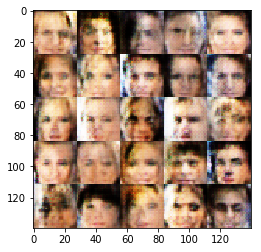

Epoch 1/1... Discriminator Loss: 1.3921... Generator Loss: 0.5820
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.3078... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.3549... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.3721... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7480


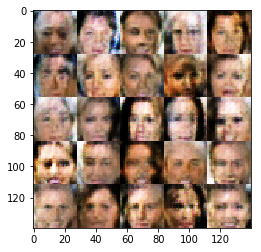

Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.2952... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.2049... Generator Loss: 0.8112


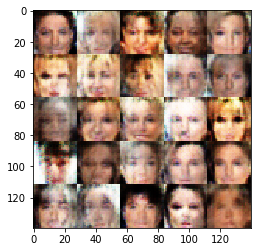

Epoch 1/1... Discriminator Loss: 1.1324... Generator Loss: 0.7375
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.8865
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.5400
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.4192
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8579


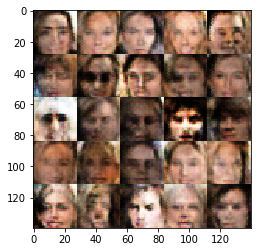

Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.1962... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.6481
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.7469


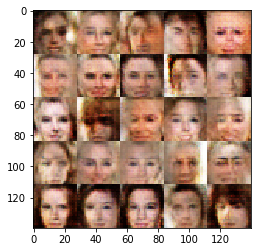

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7387
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6634
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.3662... Generator Loss: 0.7785


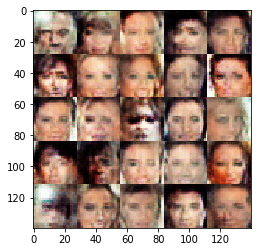

Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.5351... Generator Loss: 0.4450
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.6739
Epoch 1/1... Discriminator Loss: 1.3788... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.8246
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.6218


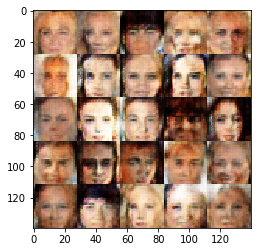

Epoch 1/1... Discriminator Loss: 1.3434... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.7559... Generator Loss: 1.3862
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.2887... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.7093
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.5967
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.6032


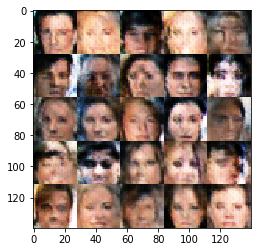

Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.4441... Generator Loss: 0.5034
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.1684... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7836


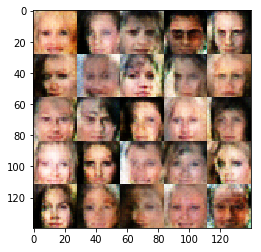

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.9080
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8186
Epoch 1/1... Discriminator Loss: 1.2037... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.6188... Generator Loss: 1.3030
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7003


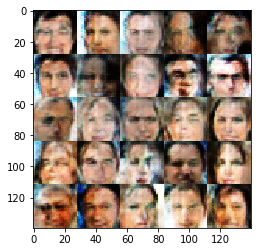

Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.6786... Generator Loss: 1.3077
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.5532
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.5179... Generator Loss: 0.4806
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.5585
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.6389


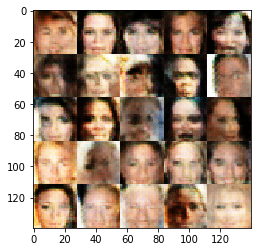

Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7793
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5296
Epoch 1/1... Discriminator Loss: 1.4076... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.6357
Epoch 1/1... Discriminator Loss: 1.8085... Generator Loss: 0.2563
Epoch 1/1... Discriminator Loss: 2.1756... Generator Loss: 1.7192
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.5484


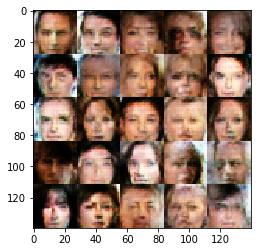

Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.3006... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.1859... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.7836
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.4792... Generator Loss: 0.3992


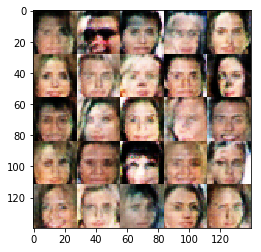

Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 1.4307... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.5731
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.5447... Generator Loss: 0.3420
Epoch 1/1... Discriminator Loss: 1.1968... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.9958
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.6110


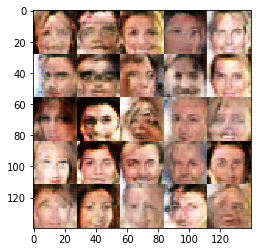

Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 0.7916
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.6785
Epoch 1/1... Discriminator Loss: 1.2055... Generator Loss: 0.7688
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.4529... Generator Loss: 0.4537
Epoch 1/1... Discriminator Loss: 1.3032... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.3766... Generator Loss: 0.5845


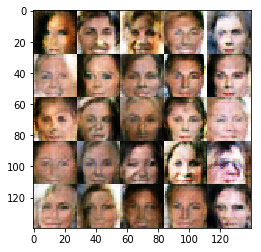

Epoch 1/1... Discriminator Loss: 1.2574... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 1.2598... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7627
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 1.2234... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.5823


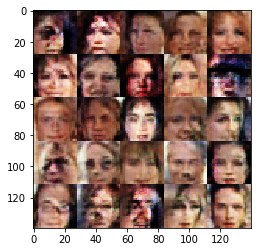

Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.3969
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6158
Epoch 1/1... Discriminator Loss: 1.3155... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7001
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.4941
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 1.0180


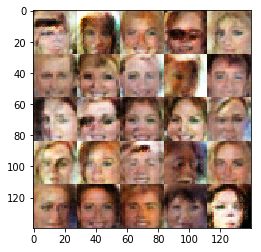

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.4056
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.4721
Epoch 1/1... Discriminator Loss: 1.3259... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 0.7554... Generator Loss: 1.0154
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.8917
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6557


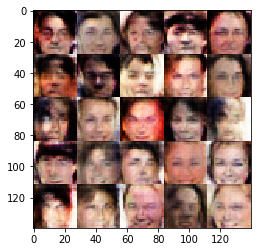

Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.5047
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.3212
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.1410... Generator Loss: 0.8870
Epoch 1/1... Discriminator Loss: 0.9552... Generator Loss: 0.8614
Epoch 1/1... Discriminator Loss: 1.4247... Generator Loss: 0.5008


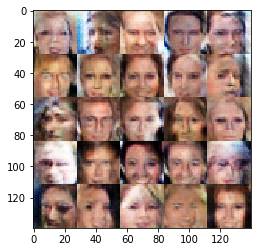

Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.5778
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.5316
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.5048
Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 0.5996


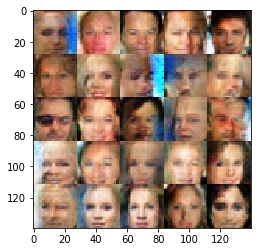

Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.5981
Epoch 1/1... Discriminator Loss: 1.1654... Generator Loss: 0.6222
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.9142
Epoch 1/1... Discriminator Loss: 1.9056... Generator Loss: 0.2195
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.6413


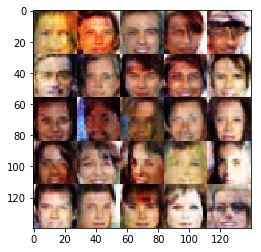

Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.4645
Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.5551
Epoch 1/1... Discriminator Loss: 1.2753... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.4591
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.9655


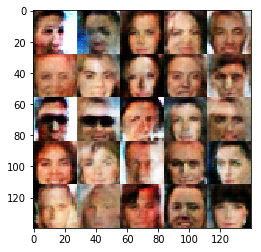

Epoch 1/1... Discriminator Loss: 1.0680... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.1517... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.5117
Epoch 1/1... Discriminator Loss: 1.3271... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3326... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.2824... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.3304... Generator Loss: 0.5903


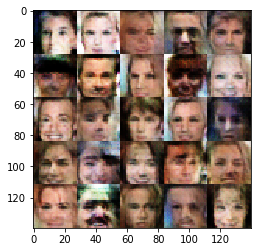

Epoch 1/1... Discriminator Loss: 1.2310... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.5136
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.3240... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 2.1718... Generator Loss: 1.8297
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6601


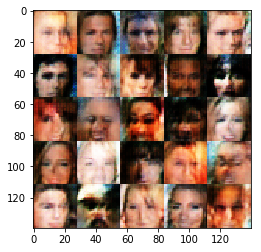

Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6103
Epoch 1/1... Discriminator Loss: 1.2995... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.5737
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.6497
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.4545


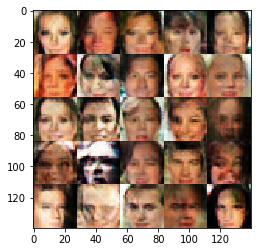

Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.3988
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.5141
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 0.5044
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 0.5993
Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.5007
Epoch 1/1... Discriminator Loss: 0.9787... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 1.1444
Epoch 1/1... Discriminator Loss: 1.5499... Generator Loss: 0.4078


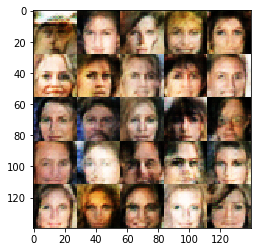

Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.4874... Generator Loss: 0.3861
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.5072
Epoch 1/1... Discriminator Loss: 1.4990... Generator Loss: 0.3738
Epoch 1/1... Discriminator Loss: 1.1915... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.4735
Epoch 1/1... Discriminator Loss: 1.5779... Generator Loss: 0.3388
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 1.7157


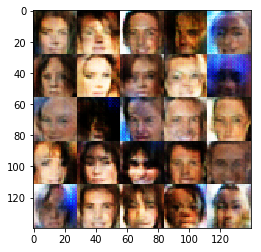

Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.3369... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.5312
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.4658
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.5880
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.5886
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.6231


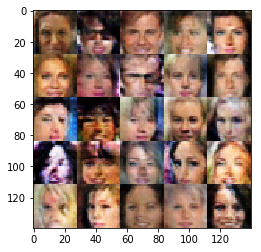

Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.4982
Epoch 1/1... Discriminator Loss: 1.0132... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.5453
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 1.1150
Epoch 1/1... Discriminator Loss: 1.5243... Generator Loss: 0.3605
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5195
Epoch 1/1... Discriminator Loss: 0.9810... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.5831


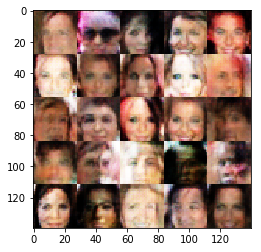

Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.4325
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.9000
Epoch 1/1... Discriminator Loss: 1.2872... Generator Loss: 0.5155
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6782
Epoch 1/1... Discriminator Loss: 1.2832... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6045
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.6050


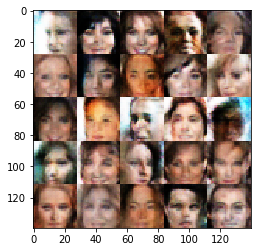

Epoch 1/1... Discriminator Loss: 1.3406... Generator Loss: 0.4779
Epoch 1/1... Discriminator Loss: 1.3904... Generator Loss: 0.4539
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.9551... Generator Loss: 1.9083
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.7939
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.2255... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.4186... Generator Loss: 0.5182
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.5014


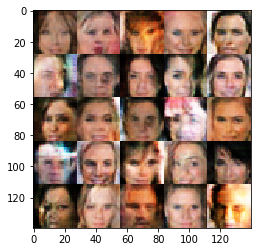

Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.7747
Epoch 1/1... Discriminator Loss: 1.2305... Generator Loss: 0.7507
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.5010
Epoch 1/1... Discriminator Loss: 1.5407... Generator Loss: 0.3907
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.5827
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.4624
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.6067


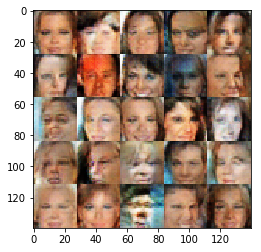

Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.3905
Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.1758... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5251
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.5971
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.9062


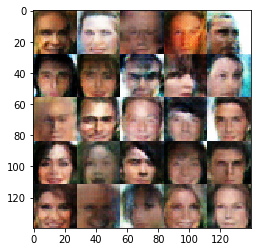

Epoch 1/1... Discriminator Loss: 1.2630... Generator Loss: 1.2554
Epoch 1/1... Discriminator Loss: 1.2010... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.5870
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.5418
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.6042
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 1.2010
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.5628
Epoch 1/1... Discriminator Loss: 1.1937... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.8218


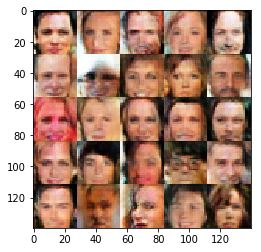

Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.1827... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.1110... Generator Loss: 0.7882
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.5008
Epoch 1/1... Discriminator Loss: 1.2145... Generator Loss: 0.6869
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.1952... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.5738
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.7182


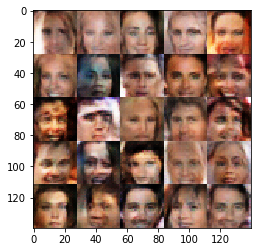

Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.4446
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.3561
Epoch 1/1... Discriminator Loss: 1.0771... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 0.9088... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.2479... Generator Loss: 0.6197


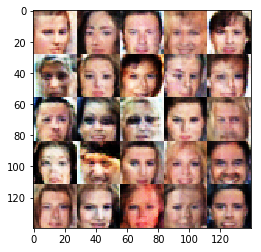

Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7999
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.5414
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.8237
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.4661


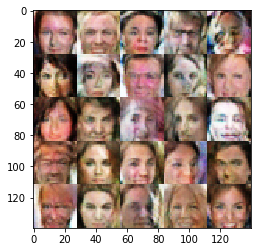

Epoch 1/1... Discriminator Loss: 1.2605... Generator Loss: 0.8712
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.0089... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.5205
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.4958
Epoch 1/1... Discriminator Loss: 1.1251... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.5017


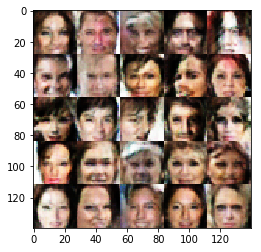

Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 1.0027
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.4445
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.5371
Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.5120
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.5015
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3280... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8828
Epoch 1/1... Discriminator Loss: 1.2325... Generator Loss: 1.3802


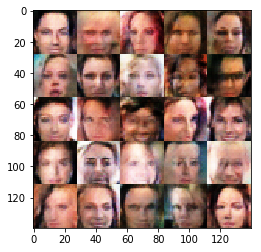

Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.0197
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.2467... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.8639
Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.9499
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.9047


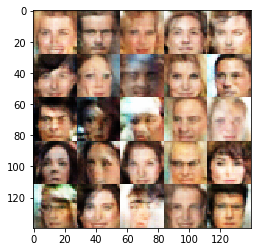

Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.6389
Epoch 1/1... Discriminator Loss: 1.1413... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.1510... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.4470
Epoch 1/1... Discriminator Loss: 1.2061... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.4559
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 1.2848
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.5015


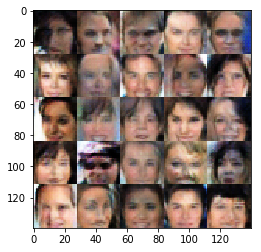

Epoch 1/1... Discriminator Loss: 1.5148... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 0.6812... Generator Loss: 1.5152
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.3320... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.6183
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.2059... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.5121
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.4247


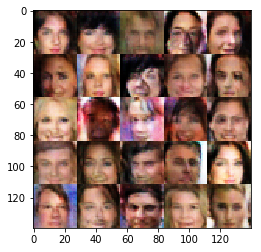

Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.1973... Generator Loss: 0.8247


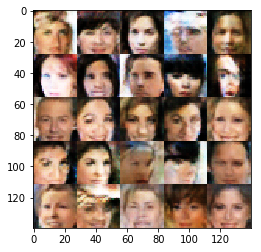

Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.6300
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.2185... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.4890
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.4756
Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 1.1907
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.6466
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.8334


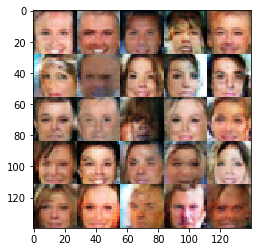

Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.5806
Epoch 1/1... Discriminator Loss: 1.2582... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.3867
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 1.2277... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.4881
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 1.2176
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.8381
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 0.7364


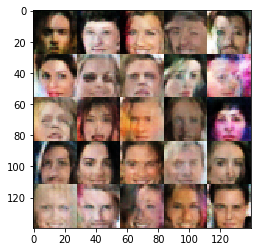

Epoch 1/1... Discriminator Loss: 0.9260... Generator Loss: 0.8392
Epoch 1/1... Discriminator Loss: 3.3191... Generator Loss: 0.0439
Epoch 1/1... Discriminator Loss: 0.8479... Generator Loss: 1.2040
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.1645... Generator Loss: 1.1436
Epoch 1/1... Discriminator Loss: 0.8050... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.5726
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 1.1942
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6918


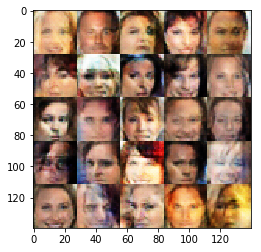

Epoch 1/1... Discriminator Loss: 1.5533... Generator Loss: 0.3786
Epoch 1/1... Discriminator Loss: 1.1650... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.5331
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.5359
Epoch 1/1... Discriminator Loss: 1.5391... Generator Loss: 0.3547
Epoch 1/1... Discriminator Loss: 1.1371... Generator Loss: 0.5448
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.5199
Epoch 1/1... Discriminator Loss: 1.1904... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.6584


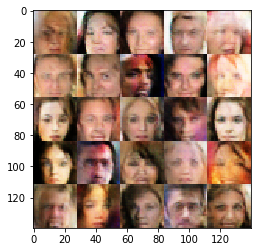

Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.4999
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.5598
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.4736
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.8754
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.2831... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 0.9675... Generator Loss: 0.6666
Epoch 1/1... Discriminator Loss: 1.0821... Generator Loss: 0.6344


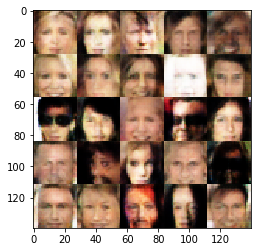

Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 0.3040
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.9271
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 0.7487
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 1.2158... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.8498


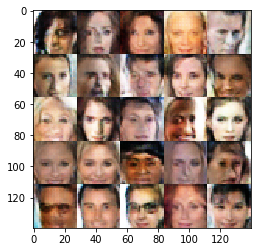

Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.5255
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.4305
Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.2657... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 0.3922
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.4518


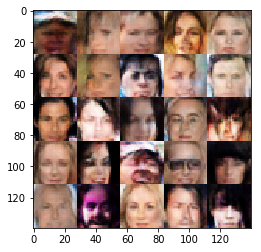

Epoch 1/1... Discriminator Loss: 1.7079... Generator Loss: 0.2521
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.2883... Generator Loss: 0.9454


In [13]:
batch_size = 32
z_dim = 65
learning_rate = 0.004
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.